In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

In [11]:
base_dir = '/Users/manav/Desktop/Data'  # Adjust this path

# Define paths to the training, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Define image size and batch size
img_height, img_width = 256, 256  # Adjust based on your images
batch_size = 32

# Create training data generator with aggressive data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    zoom_range=0.3,
    shear_range=0.3,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

# Validation and test data generators (only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 522 images belonging to 2 classes.
Found 301 images belonging to 2 classes.
Found 535 images belonging to 2 classes.


In [13]:
base_model = EfficientNetB0(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Unfreeze some of the last layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Set callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [15]:
epochs = 20

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 146s 7s/step - accuracy: 0.4876 - loss: 0.7235 - val_accuracy: 0.4585 - val_loss: 0.6934 - learning_rate: 1.0000e-04
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 765ms/step - accuracy: 0.5638 - loss: 0.6895 - val_accuracy: 0.5415 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 771ms/step - accuracy: 0.5534 - loss: 0.6696 - val_accuracy: 0.5415 - val_loss: 0.6921 - learning_rate: 1.0000e-04
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 818ms/step - accuracy: 0.6010 - loss: 0.6603 - val_accuracy: 0.5415 - val_loss: 0.6922 - learning_rate: 1.0000e-04
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 786ms/step - accuracy: 0.6734 - loss: 0.6073 - val_accuracy: 0.5415 - val_loss: 0.6922 - learning_rate: 1.0000e-04
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 780ms/step - accuracy: 0.6852 - loss: 0.5753 - val_accuracy: 0.5415 - val_loss: 0.6929 - learning_rate: 1.0000e-04
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 775ms/step - accur

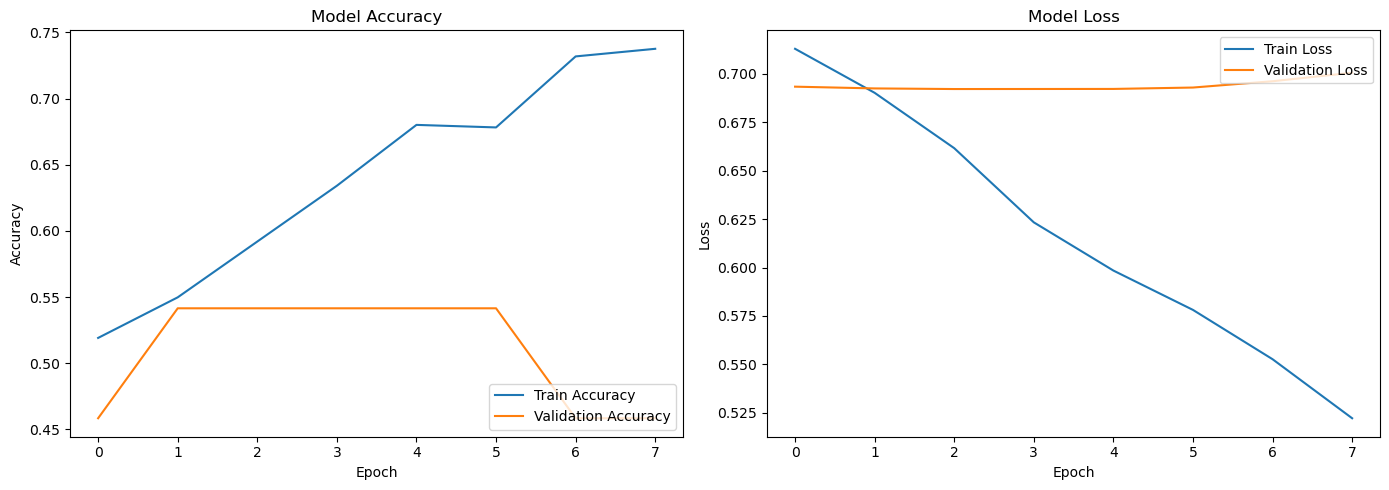

In [16]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()